# Supernova distances and redshifts - Part 2

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

(35.0, 50.0)

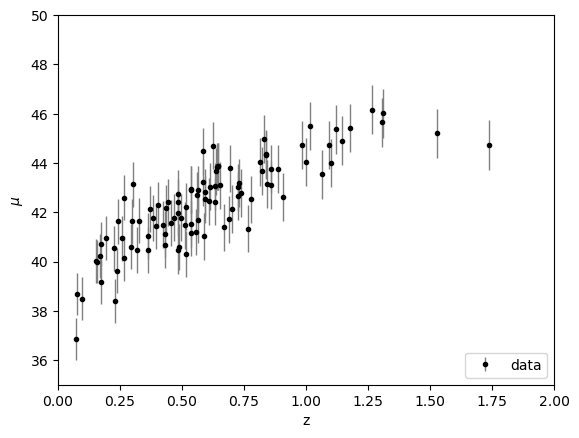

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

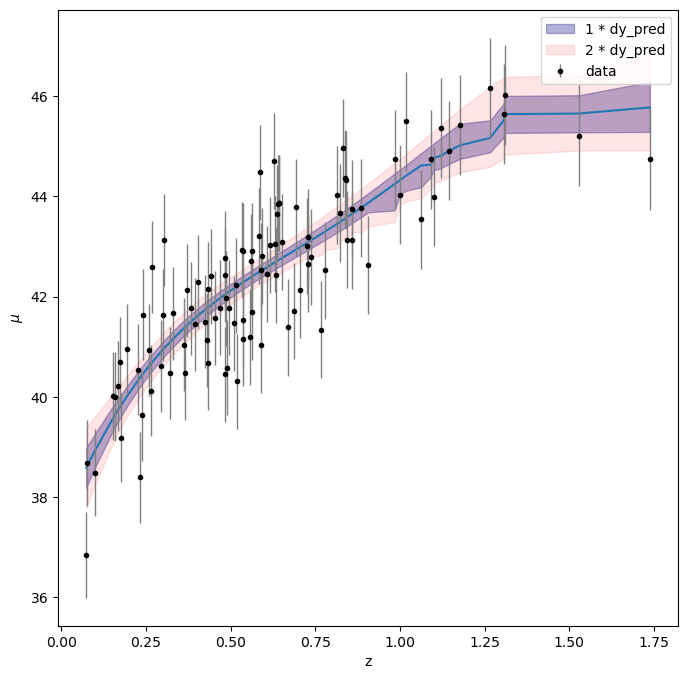

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X = z_sample.reshape(-1,1)
y = mu_sample
dy = dmu

#kernel = RBF(1.0)
kernel = 1*RBF(length_scale = 1, length_scale_bounds='fixed')

gp = GaussianProcessRegressor(kernel = kernel, alpha= dmu,random_state = 0)
gp.fit(X,y)
y_pred, dy_pred = gp.predict(X, return_std=True)


fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot()

ax.plot(np.sort(X[:,0]),np.sort(y_pred))
ax.fill_between(np.sort(X[:,0]),np.sort(y_pred - dy_pred),np.sort(y_pred + dy_pred),color= 'navy',alpha = 0.3, label = '1 * dy_pred')
ax.fill_between(np.sort(X[:,0]),np.sort(y_pred - 2 * dy_pred),np.sort(y_pred + 2 * dy_pred),color= 'red',alpha = 0.1,label = '2 * dy_pred')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

ax.set_xlabel("z")
ax.set_ylabel("$\mu$")
ax.legend()

---
> # Physical theory: $\Lambda$CDM

---

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$.
$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$
- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model.

**MCMC**

The MCMC method followos the following steps:
- *Define  Likelihood*: I choose as Likelihood a gaussian where for $\mu$ = mu_model and $\sigma$= dmu
- *Define Prior*: I choose a uniform prior
- *Compute the Posterior*: Compute the prodoct between Prior and Likelihood

In [4]:
from astropy.cosmology import LambdaCDM
import scipy.stats as scistats


def model(z, H_0, Omega_m):
    cosmo = LambdaCDM(H0=H_0, Om0=Omega_m, Ode0= 1 - Omega_m)
    return cosmo.distmod(z).value

def LogLikelihood(theta):
    Omega_m, H_0 = theta
    if Omega_m <0:
        return -np.inf
    else:
        mu_model = model(z_sample,H_0,Omega_m)
        
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

#uniform prior
def LogPrior(theta):
    Omega_m, H_0 = theta
    
    if 50 < H_0 < 100 and 0.1 < Omega_m < 1:
        return 0.0
    return -np.inf

def LogPosterior(theta):
    return LogPrior(theta) + LogLikelihood(theta)

Let's use ***emcee***

In [5]:
import emcee

ndim = 2  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
#burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.array([0.5,80]) + 1e-1* np.random.randn(nwalkers, ndim)

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps)

print("done")

done


In [6]:
samples = sampler.get_chain()

tau = sampler.get_autocorr_time()

flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)

C:\Users\utente\AppData\Local\Temp\ipykernel_24080\3347298167.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(samples[:, :, i], "k", alpha=0.3, c='navy')


'\n#Plot \nplt.plot(x,traceplot)\nplt.xlim(0,2000)\n\nplt.title("Trace plot")\n'

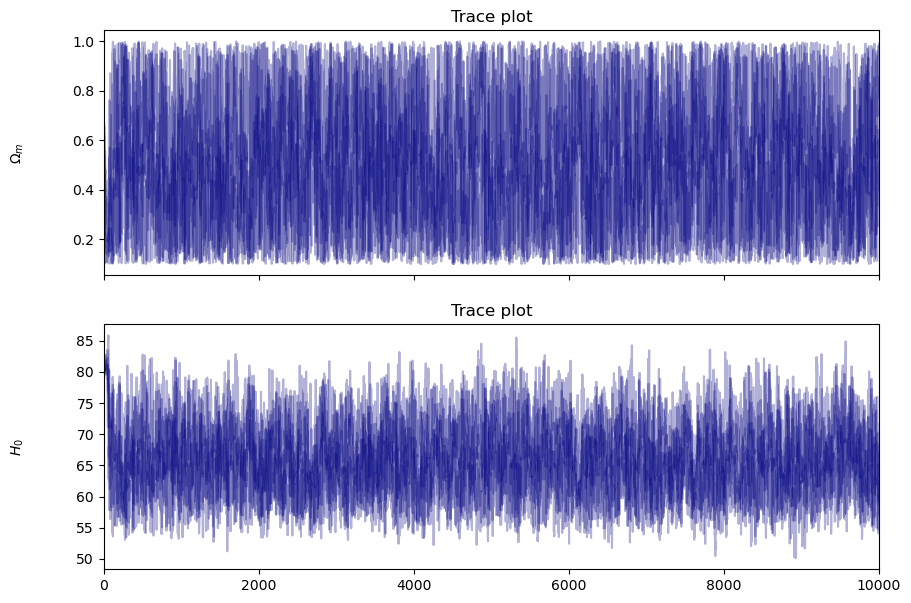

In [7]:
#Traceplot
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

labels = ["$\Omega_m$", "$H_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.set_title("Trace plot")
    ax.plot(samples[:, :, i], "k", alpha=0.3, c='navy')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    

'''
#Plot 
plt.plot(x,traceplot)
plt.xlim(0,2000)

plt.title("Trace plot")
'''

From these traceplot we can see that we are in a **Goldiloks scenario**. So it's ok!

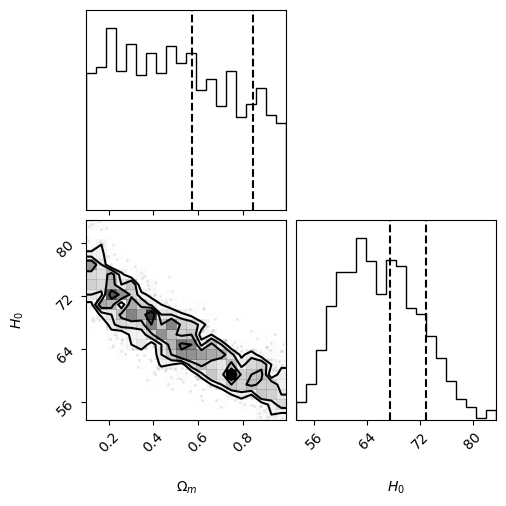

In [8]:
#Plot hte posterior
import corner
figure = corner.corner(flat_samples,labels=[r"$\Omega_m$",r"$H_0$"],quantiles=[0.60,0.87],show_title =True)

C:\Users\utente\anaconda3\lib\site-packages\astropy\cosmology\flrw\base.py:1284: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


(35.0, 50.0)

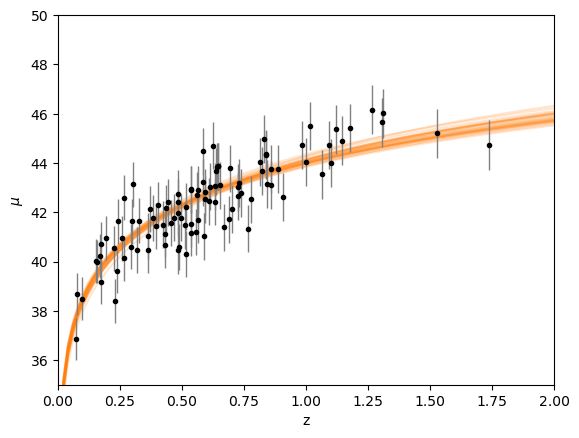

In [9]:
z = np.linspace(0,2,100)

for Om,H0, in flat_samples[::50]:
    plt.plot(z, model(z, H0, Om),c='C1',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    

**NESTED SAMPLE**

We are going to use ***dynesty***

In [10]:
import dynesty
import numpy as np

# Define the dimensionality of our problem.
ndim = 2

# Define our 2-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(np.linalg.det(C)))  # ln(normalization)


In [11]:
# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    mins = np.array([0.1,30])
    maxs = np.array([1,100])
        
    return  mins + u*(maxs-mins)

In [12]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

1669it [00:26, 63.07it/s, +500 | bound: 0 | nc: 1 | ncall: 14210 | eff(%): 15.821 | loglstar:   -inf < -132.814 <    inf | logz: -135.291 +/-  0.047 | dlogz:  0.001 >  0.509]


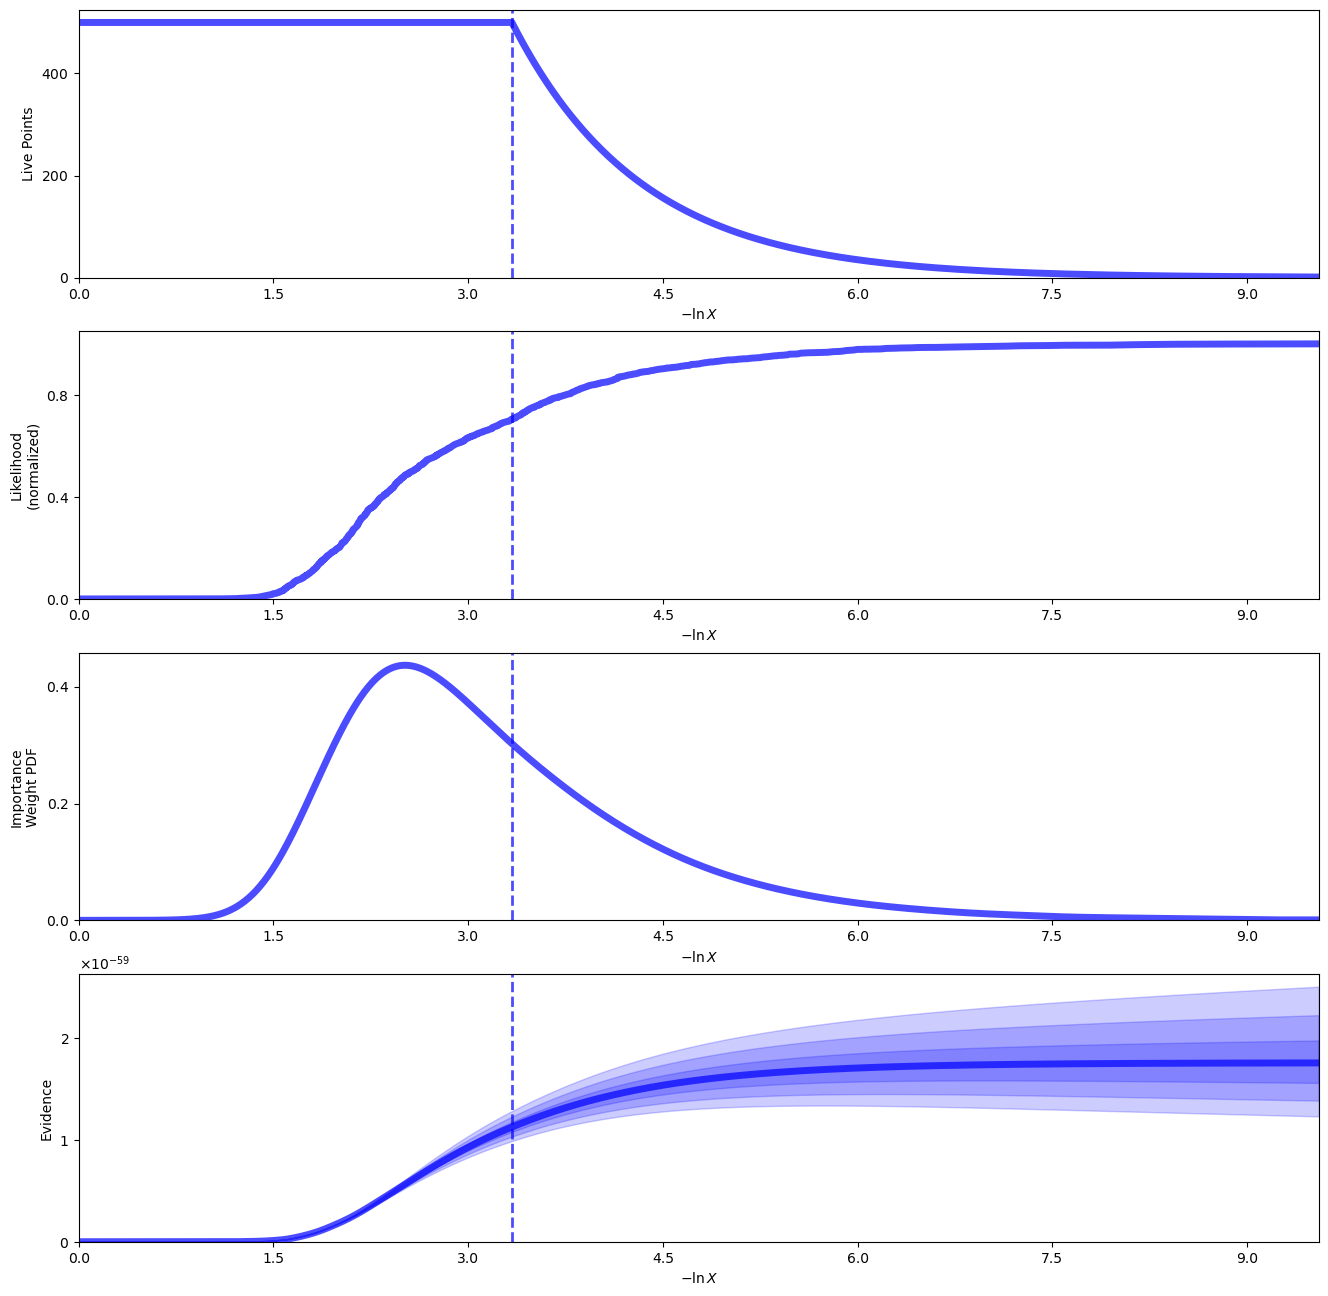

In [13]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

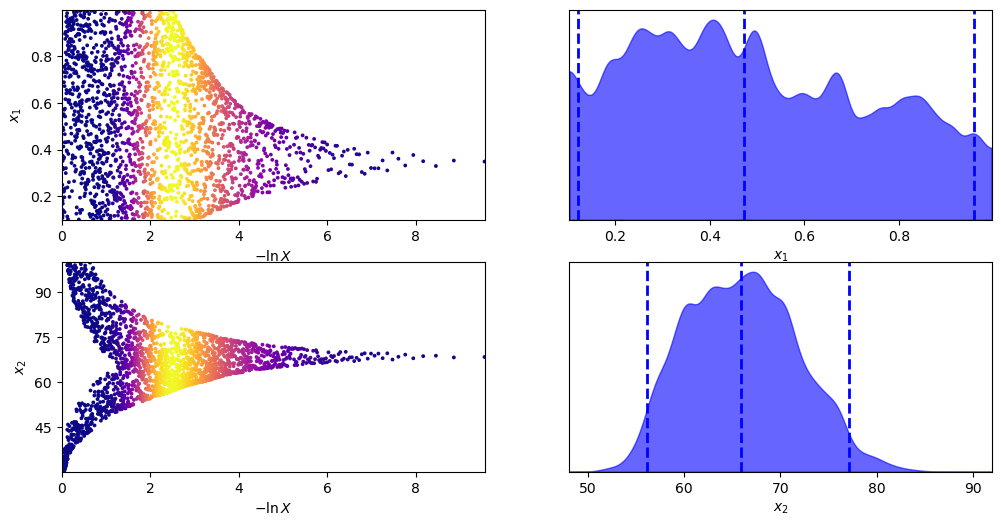

In [14]:
tfig, taxes = dyplot.traceplot(sresults)

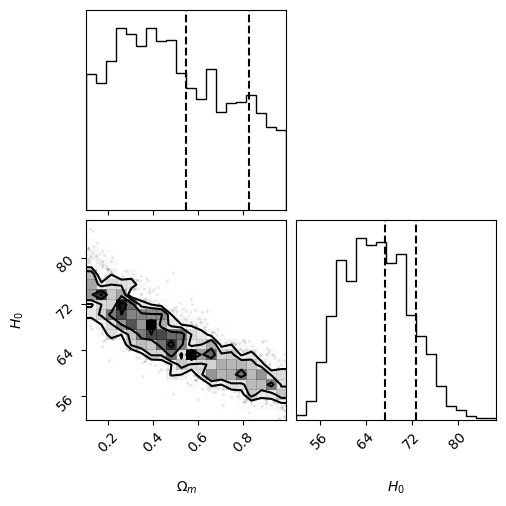

In [15]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)
figure = corner.corner(samples_equal,labels=[r"$\Omega_m$",r"$H_0$"],quantiles=[0.60,0.87],show_title =True)

C:\Users\utente\anaconda3\lib\site-packages\astropy\cosmology\flrw\base.py:1284: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


(35.0, 50.0)

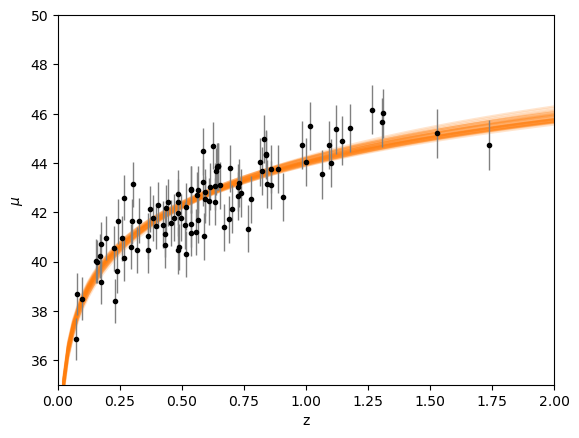

In [16]:
for Om,H0, in samples_equal[::50]:
    plt.plot(z, model(z, H0, Om),c='C1',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    

> *How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?*

In [17]:
ndim = 1

In [18]:
def LogLikelihood_Mod(theta):
    
    H_0 = float(theta)
    Omega_m =1
    mu_model = model(z_sample,H_0,Omega_m)
    
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    mins = np.array([30.])
    maxs = np.array([100.])
        
    return  mins + u*(maxs-mins)

In [19]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood_Mod, ptform, ndim,nlive=1000)
sampler.run_nested()
sresults_1 = sampler.results

2820it [00:27, 103.46it/s, +1000 | bound: 0 | nc: 1 | ncall: 17028 | eff(%): 23.833 | loglstar:   -inf < -133.530 <    inf | logz: -135.966 +/-    nan | dlogz:  0.001 >  1.009]


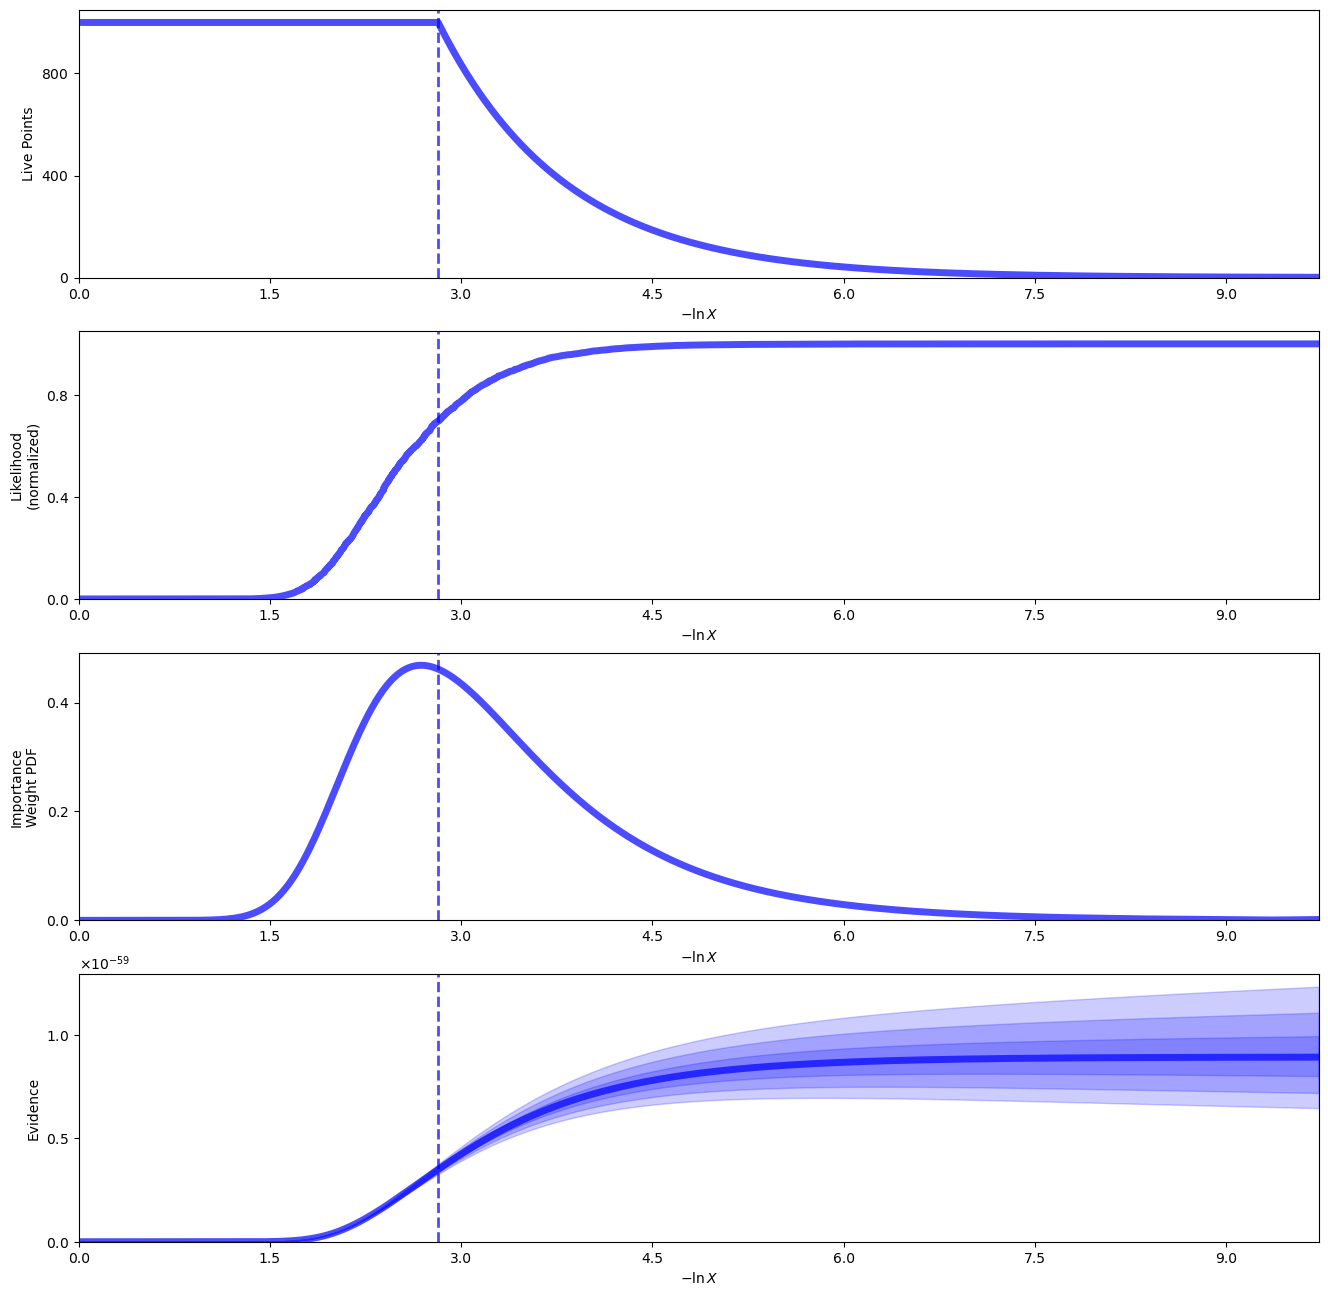

In [20]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_1)

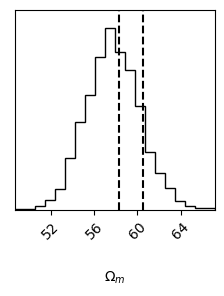

In [21]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults_1.samples  # samples
weights = np.exp(sresults_1.logwt - sresults_1.logz[-1])  # normalized weights

# Resample weighted samples.
samples_equal_1 = dyfunc.resample_equal(samples, weights)
figure = corner.corner(samples_equal_1,labels=[r"$\Omega_m$",r"$H_0$"],quantiles=[0.60,0.87],show_title =True)

C:\Users\utente\anaconda3\lib\site-packages\astropy\cosmology\flrw\base.py:1284: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


(35.0, 50.0)

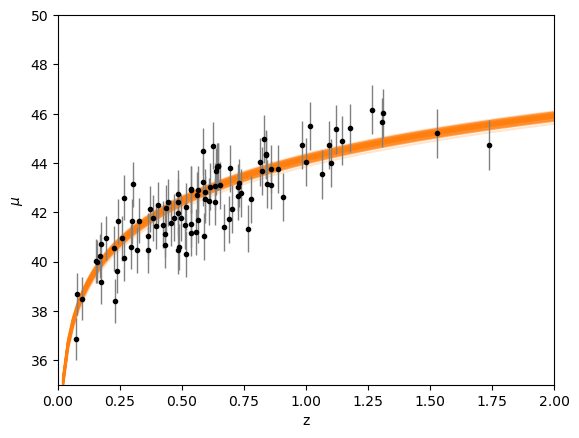

In [22]:
for H0, in samples_equal_1[::50]:
    plt.plot(z, model(z, H0, Om),c='C1',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    

Let's compute the **Savage Dickey density ratio** approximation in order to compare these two Bayesian models:
- Model without dark energy: $\Omega_m$=1
- Model with dark energy: $\Omega_m$ different from 1

In [23]:
SD =  sresults.logz[-1]/sresults_1.logz[-1] #SD is in log scale
print("The value of Savage Dickey density ratio is:%f "%np.exp(SD))

The value of Savage Dickey density ratio is:2.704818 


This Bayes factor represent a '*Barely worth mentioning*' evidence respect the model with dark energy

> -----

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.

- Think about the pdf of these data in  𝑧
 .
- Using both the GPR fit and your latest  Λ
 CDM fit, generate a set of  𝜇
  measurements that respects the statistical properties of the data you were given.

In [24]:
samples_equal[np.random.choice(samples_equal.shape[0])]

array([ 0.63044946, 69.41296335])

In [25]:
z_vals = np.linspace(0,5,1000)
mu_nested=[]
mu_GPR=[]
for z in z_vals:
    Om,H0 = samples_equal[np.random.choice(samples_equal.shape[0])]

    mu_nested.append(model(z,H0,Om))
    
    mu_fit, sigma = gp.predict([[z]], return_std=True)
    mu_GPR.append(np.random.normal(loc=mu_fit,scale=sigma))

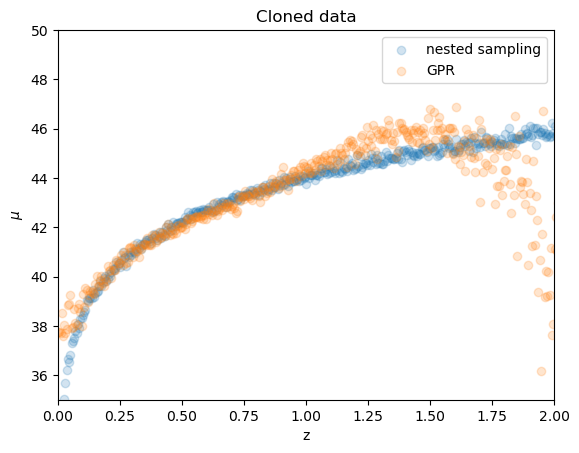

In [26]:
plt.scatter(z_vals,mu_nested,alpha=0.2,label="nested sampling")
plt.scatter(z_vals,mu_GPR,alpha=0.2,label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("Cloned data")
plt.legend()